# Techniques of High Performance Computing - Assignment 1

## Name: John Duffy

## Student Number: 19154676

# Question 1

## Random Walk on a Lattice

### Program Description

A particle is positioned at each of the (x, y) coordinates of a N x N lattice grid.
M simualtions are carried out to determine the probability of each particle reaching
the bottom boundary of the grid during a random walk of up to S steps.

This is a compute bound problem, as there is no data shared between simulations.
The result of each simualtion is independent and the result is success (if the bottom
boundary is reached) or failure (if any other boundary is reached, or S steps are
completed without a boundary being reached). A data structure is used to count the
number of successes, which is subsequently turned into a probability.

This is an integer problem. The random walks are implemented as a single integer
step up, down, left or right. And the success counts are integer. Therefore, to avoid
floating point overhead, as much as possible is done using integer data
structures (which also results in a memory saving) and integer operations. A floating
point data sructure is used at the end of the program to store the probabilties.

Numpy arrays are used at the outset as the data structure to store the random walk
success counts (an integer array) and the resulting probabilities (a float array). 
Matplotlib is then used to display the probabilities.

#### Program Structure Optimisation

Because this is a compute bound problem, the structure of the program was consisdered
carefully to ensure function calls and repeated operations are minimised. Function/library
calls considered likely to be expensive, e.g. numpy.random.ranint(), are done once outside
of a loop rather than multiple times inside a loop.

#### Pre Optimisation Results

Using only Numpy the following baseline results were obtained:

* M: 1000
* N: 50
* S: N * N

* Time: 689 seconds
* CPU Load: 13%


##### 2019-10-19_Refinement_1

The important thing is that each grid position is exposed to M independent random walks. It
not important that each grid position is exposed to different M independent random walks.
So, rather compute S random walk steps for each grid position for each simulation (M * N * N
calls to numpy.random.randint()), we can compute S random walk steps for each simulation and
apply the same steps to each grid position (M calls to numpy.random.randint()). A saving of
a factor of N * N calls to numpy.random.randint(). This also has the added benefit of moving
the numpy.random.randint() call out of the random_walk() function making it easier to
further optimise this function. The S random walk steps are now passed into random_walk() as
a parameter.

* M: 1000
* N: 50
* S: N * N

* Time: 677 seconds. Eh? Surprising and disappointing! Passing steps array problematic?

* CPU Load: 13%

#### Optimisation Results

##### 2019-10-19_Refinement_1

Added @njit decorator to random_walk() function.

* M: 1000
* N: 50
* S: N * N

* Time: 5.2 seconds
* CPU Load: 13%

##### 2019-10-23_Refinement_1

Created a lattice_random_walk() function with the @njit(parallel=True) decorator. This function
calls random_walk() for each lattice position, using prange to do this in parallel.

Run with M = 1,000

* M: 1000
* N: 50
* S: N * N

* Time: 1.7 seconds
* CPU Load: 85%

Run with M = 10,000

* M: 10000
* N: 50
* S: N * N

* Time: 15.5 seconds (a linear increase in time)
* CPU Load: 85%

Run with M = 100,000

* M: 100000
* N: 50
* S: N * N

* Time: 151 seconds (a linear increase in time)
* CPU Load: 90%


#### Import required libraries

In [153]:
import numpy as np
import time

from numba import njit, prange

In [154]:
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start


In [155]:
# Define global variables used in the program.

# Number of trials.

M = 1000


# Grid size, N x N.

N = 50


# The maximum number of random walk steps before terminating if a boundary is not reached.

S = N * N


In [156]:
@njit
def random_walk(x, y, steps):
    """
    This function takes as input the (x, y) position of a particle on an N x N grid, and then
    takes up to S random walk steps up, down, left or right. The function returns True if the
    bottom boundary is reached, or the bottom boundary is the initial position. The function
    returns False if S steps are taken and no boundary is reached, or as soon as the
    top, left or right boundarie are reached.
    
    The intention is to Just in Time compile this function using Numba/njit, so this code is
    as close to simple 'C' like as possible.
    """
 
    # Parameter sanity checks...
    
    assert x >= 1 and x <= N, "x bound error"
    assert y >= 1 and y <= N, "y bound error"
    
 
    # If the intial position of the particle is on a boundary, no need to start a random walk.
    # The order of tests selected to return True as soon as possible.
    
    if y == 1: return True  # Bottom   
    if y == N: return False # Top    
    if x == 1: return False # Left    
    if x == N: return False # Right
    

    # Store initial (x, y) position...
    
    new_x = x
    new_y = y
    

    # Start the random walk with the step directions defined as...

    # 0 == down
    # 1 == up
    # 2 == left
    # 3 == right
       
    for s in range(S):

        # Take a step, and test for a boundary conditions as soon as possible...

        if steps[s] == 0:
            new_y -= 1
            if new_y == 1:
                return True

        if steps[s] == 1:
            new_y += 1
            if new_y == N:
                return False
            
        if steps[s] == 2:
            new_x -= 1
            if new_x == 1:
                return False

        if steps[s] == 3:
            new_x += 1
            if new_x == N:
                return False
    

    # Boundary not reached...
    
    return False


In [157]:
@njit(parallel=True)
def lattice_random_walk(successes, steps):
    """
    This function...
    """
    for x in range (1, N + 1):
        for y in prange (1, N + 1):
            if random_walk(x, y, steps):
                successes[x - 1, y - 1] += 1
    

In [158]:
# Run M random walk simualtions on each (x, y) grid position.

with Timer() as t:

    # Define a successes array. This array counts the numbers of times the bottom boundary
    # is reached for each position on the lattice over M simualtions. Success counts are
    # integers so this array can use an integer datatype so save some memory, reduce cache
    # hits and reduce floating point overhead.
    
    successes = np.zeros((N, N), dtype='uint32')


    # Define a probabilities array. Probabilities are calculated at the end of the program 
    # to avoid floating point overhead.

    probabilities = np.zeros((N, N))


    # Conduct M simulations.
    
    for m in range(M):
        
        # The call to np.random.randint() appears probelmatic for Numba. So, for each simulation
        # generate the random steps that will be taken in advance and pass as a parameter to
        # lattice_random_walk().
        
        steps = np.random.randint(4, size=S)
        
        
        # Conduct a random walk over the lattice.
        
        lattice_random_walk(successes, steps)
        

    # Determine the probabilities.
    
    probabilities = successes / M
    

print("Total time: {0}".format(t.interval))


Total time: 1.8314950466156006


In [159]:
# Print the probabilites array for a sanity check.

# NB We are using (1..N, 1..N) as (x, y) coordinates in a Cartesian sense, but Numpy
# uses [row, column] starting in the top left. This means the Cartesian [x = 1, y = 1)
# position is the top left [row = 1, col = 1] ndarray position. So, we will need to
# rotate the array 90 degrees left for viewing.

print(probabilities)


[[1.    0.    0.    ... 0.    0.    0.   ]
 [1.    0.489 0.286 ... 0.    0.    0.   ]
 [1.    0.674 0.48  ... 0.002 0.001 0.   ]
 ...
 [1.    0.698 0.508 ... 0.003 0.003 0.   ]
 [1.    0.481 0.297 ... 0.001 0.001 0.   ]
 [1.    0.    0.    ... 0.    0.    0.   ]]


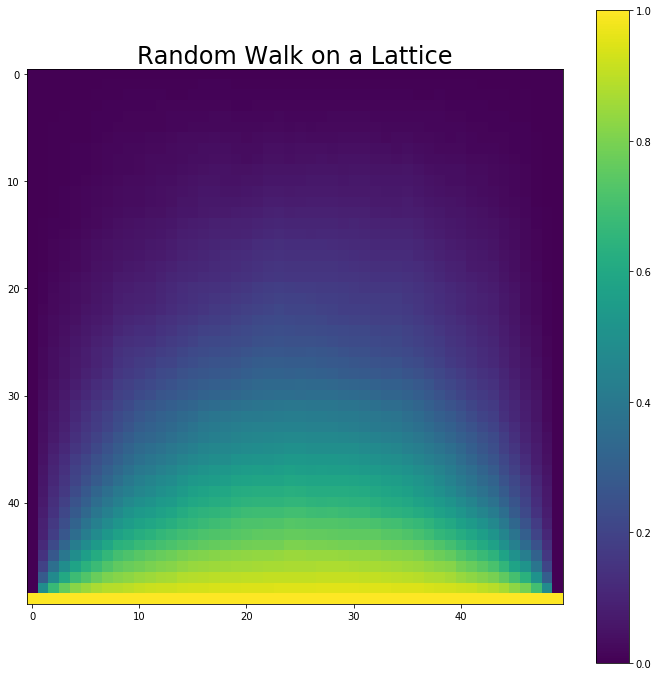

In [160]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12.0, 12.0))

ax = fig.add_subplot(111)

#im = ax.matshow(np.rot90(probabilities)) # Convert from Numpy [row, col] to Cartesian [x, y].

plt.imshow(np.rot90(probabilities))

#ax.set_aspect('auto')
ax.set_title('Random Walk on a Lattice', fontsize=24)

fig.colorbar(im)

plt.show()

## Convergence as Random Walk Trials Increase

To measure convergence to 

# Question 2

## Potentials Generated by Random Particles

### Program Description

#### Part I

Part I of the program implements an efficient method to compute and visualise f(r)
for 1 < r < 10. This takes the form of a function...

#### Part II

Part II uses the function implemented in Part I to determine the influence of the
parameters N, M and T (the number of random trials) by calling the function with
differing values of N, M, and T.

### Program Implementation

The circular/angular nature of Question 2 naturally suggests the use of polar co-ordinates.
This will reduce coding complexity by matching the program structure to the problem as
closely as possible.

Polar co-ordinates are not a basic data type in Python so it would be tempting to create
a new 'polar' type to implement the program. But doing so would lead to increased work
and extra complexity. However, complex numbers are a basic type and can be used to
represent circular/angular quantities. With the additional benefit that because they are
a basic type then all of the standard Python operators/functions/libraries can be used
normally. This program uses the complex exponential form of complex numbers in the
function f(r).

### Program Optimisations

Using only Numby, an initial benchmark for f(1000, 1000, 8.0) was timed using %%timeit:

11.2 ms ± 85.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)




## Part I

### Implement and Efficient Method to Compute and Visualise f(r) for 1 < r < 10

In [161]:
import numexpr as ne
import numpy as np
import time

from numba import njit, prange


In [162]:
a = np.array([0 + 1j * 0, 0 + 1j * 1, 0 - 1j * 1])
b = np.array([1 + 1j * 0, 2 + 1j * 0, 3 + 1j * 0])

print(np.linalg.norm(np.subtract.outer(a, b)))

distances = np.absolute(np.subtract.outer(a, b))

print(distances)

print(np.sum(np.log(distances)))

6.928203230275509
[[1.         2.         3.        ]
 [1.41421356 2.23606798 3.16227766]
 [1.41421356 2.23606798 3.16227766]]
6.396929655216146


In [163]:
def f(m, n, r, plot=False):
    """
    This function evaluates f(r) with m equally spaced evaluation positions
    on a circle of radius r, and with n randomly positioned unit charges inside
    the unit circle. Both m and n are passed as parameters, as is r. 
    """
    
    # Generate m evenly spaced evaluation positions around a circle of radius r.

    evaluation_positions = np.zeros((m), dtype='complex64')
    
    for i in range(m):
        evaluation_positions[i] = r * np.exp(1j * (2.0 * np.pi / m) * i)


    # Generate n random unit charges inside the unit circle.
    # Note: Numpy random.random() generates a random float [0.0, 1.0).
    
    charge_positions = np.zeros((n), dtype='complex64')
    
    for i in range(n): 
        charge_positions[i] = np.random.random() * np.exp(1j * np.random.random() * (2.0 * np.pi))
        
    
    # Visual sanity check.
    
    if plot == True:

        fig = plt.figure(figsize=(12.0, 12.0))

        for i in range(m):
            plt.polar(np.angle(evaluation_positions[i]), np.absolute(evaluation_positions[i]), 'ro')
    
        for i in range(n):
            plt.polar(np.angle(charge_positions[i]), np.absolute(charge_positions[i]), 'bo')

        plt.title('Evaluation of Function f(m, n, r)', fontsize='14')
        
        plt.show()


    # Calculate the distance between each evaluation position and charge position.
    # the Numpy ufunc subtract.outer() generates the complex number difference between
    # each evaluation position and each charge. The Numpy absolute() function then
    # converts each complex number into a scalar length, the distance.
    
    distances = np.zeros((m, n))
    
    distances = np.absolute(np.subtract.outer(evaluation_positions, charge_positions))
    

    # Calculate the potential for each distance.
    
    potentials = np.zeros((m, n))
    
    potentials = 1.0 / (2.0 * np.pi) * np.log(distances)
    

    # Return the potential per evaluation position per unit charge.
    
    return np.sum(potentials) / m / n


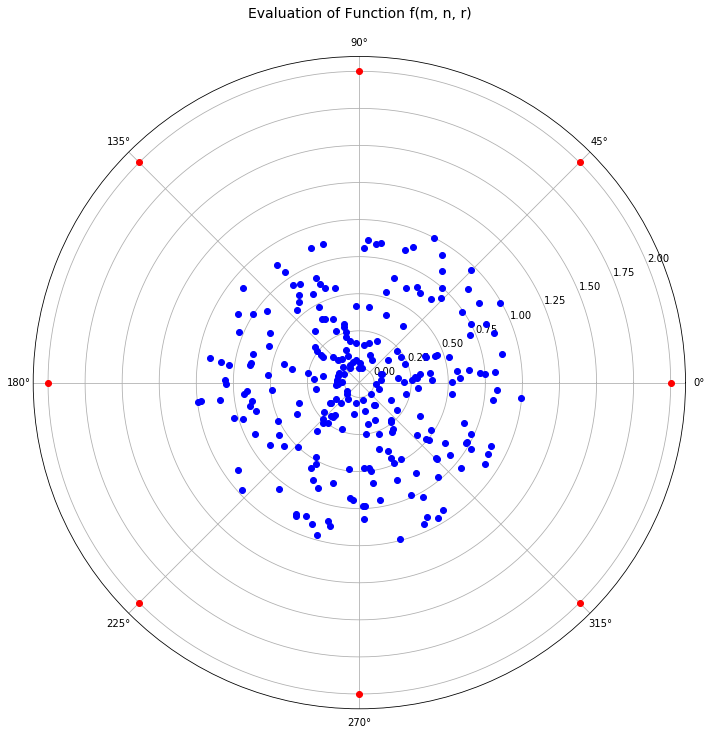

f(8, 256, 2, True) = 0.11031819134950638


In [164]:
# A sanity check of the function f()...

m = 8
n = 256
r = 2
p = True # Plot

print('f({m}, {n}, {r}, {p}) = {result}'.format(m=m, n=n, r=r, p=p, result=f(m, n, r, True)))

In [165]:
%%timeit

# A speed check of the function f()...

f(64, 1024, 8.0)


2.67 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


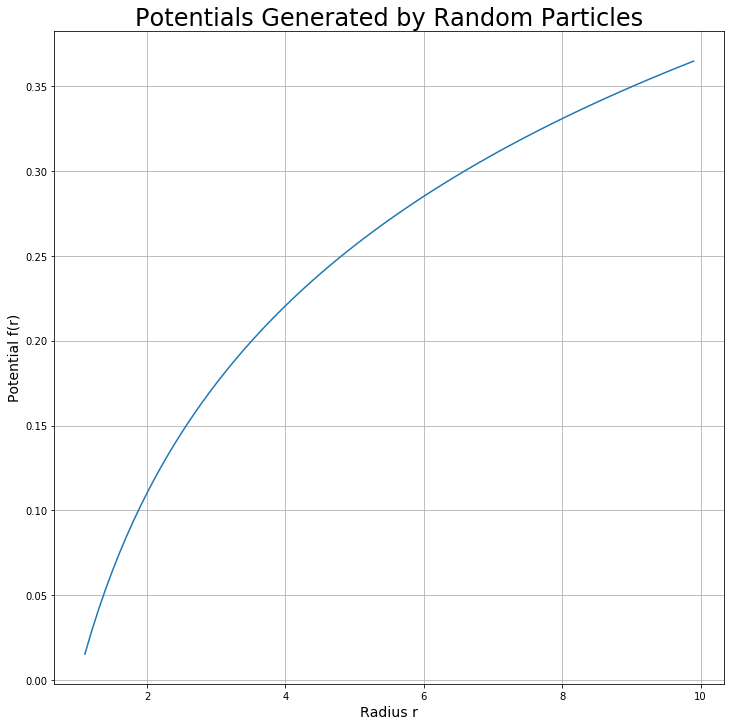

In [166]:
%matplotlib inline

import matplotlib.pyplot as plt

# Visualise f(r) for the following values of m and n, in the interval 1 < r < 10.

m = 64
n = 1024


# Generate r and f(r) data in the interval [1.1, 9.9] in 0.1 increments.

for s in range(89):
    data[s, 0] = 1.1 + s * 0.1
    data[s, 1] = f(m, n, 1.1 + s * 0.1)


fig = plt.figure(figsize=(12.0, 12.0))

ax = fig.add_subplot(111)

ax.plot(data[:,0], data[:,1])

ax.set_xlabel('Radius r', fontsize=14)
ax.set_ylabel('Potential f(r)', fontsize=14)

ax.set_title('Potentials Generated by Random Particles', fontsize=24)

plt.grid()
plt.show()

## Part II

### Estimate the Expected Value e(r), and the Influence of the Parameters N, M and T (Random Trials)

A single particle at the centre of the unit circle...

In [167]:
@njit
def u0(r):
    """
    This function returns the potential at radius r generated by a single particle
    positioned at the centre of the unit circle.
    """
    
    return 1.0 / (2.0 * np.pi) * np.log(r)


In [168]:
%%timeit

# Test u0(r)...

u0(8.0)

120 ns ± 1.43 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [169]:
def e(m, n, r):
    """
    This function returns the expected value e(r) for the relative difference of u0(r) and f(r).
    Values of m and n are passed as parameters for ease of iteration over parameter values when
    calling this function from outer loops.
    """
    return (f(m, n, r) - u0(r)) / u0(r)
    

In [170]:
%%timeit

# Test e(m, n, r)...

e(64, 1024, 2)

2.78 ms ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
T = 512

M = 8
N = 1024

R = 89 # Steps in interval [1.1, 10) in 0.1 increments

e_data = np.zeros((T, M, N, R))

for t in range(1, T):
    for m in range(1, M):
        for n in range(1, N):
            for r in range(R):
                e_data[t, m, n, r] = e(m, n, 1.1 + r * 0.1)

